# Brain Tumor Classifier using CNN

### Importing all the necessary libraries

In [51]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D

### Loading data and dividing them into Training, Validation

In [52]:
train_ds, val_ds = keras.preprocessing.image_dataset_from_directory(
    'Training',
    validation_split = 0.2,
    subset = "both",
    seed = 100,
    image_size = (128, 128),
    batch_size = 16
)

Found 5712 files belonging to 4 classes.
Using 4570 files for training.
Using 1142 files for validation.


Storing class names into a variable

In [4]:
classes = train_ds.class_names
classes

['glioma', 'meningioma', 'notumor', 'pituitary']

### Visualizing the Data

Plotting first 16 images i.e 1ˢᵗ batch

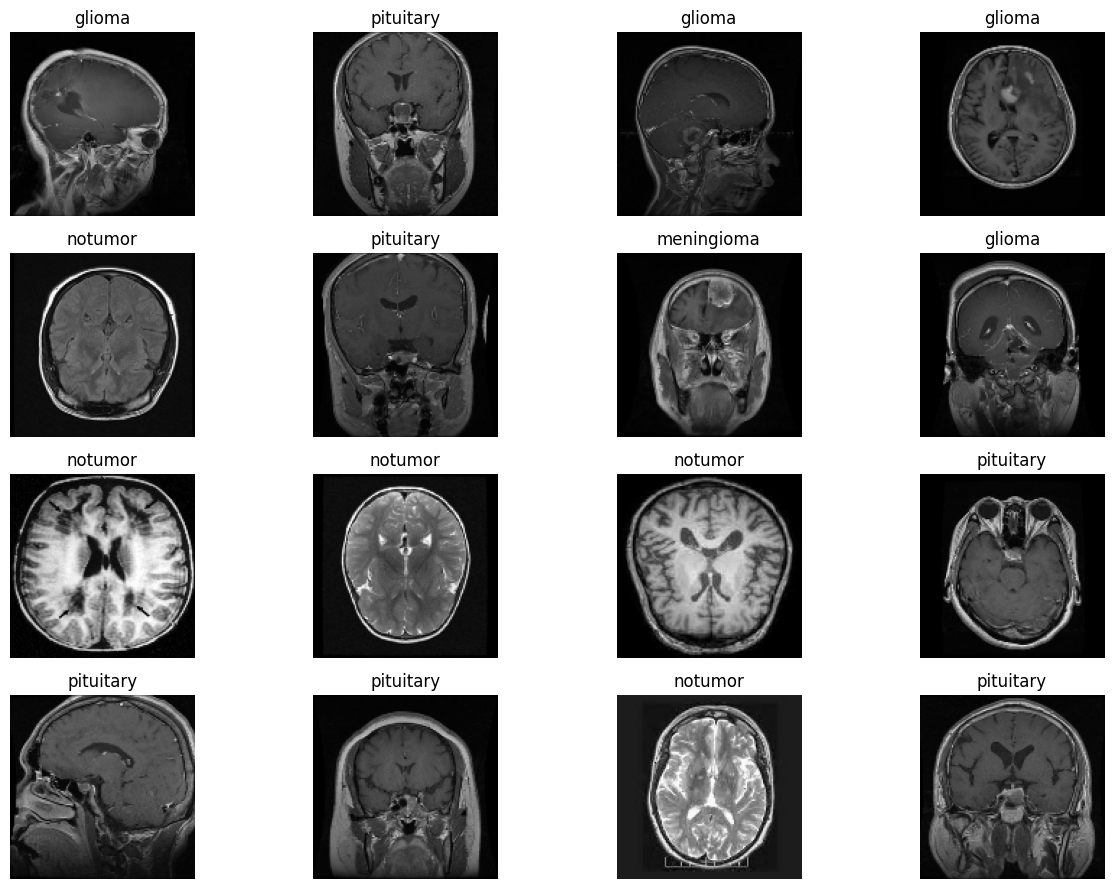

In [53]:
x, y = next(train_ds.as_numpy_iterator())

def plot_images(x, y):
    plt.figure(figsize=[15, 11])
    for i in range(16):
        plt.subplot(4, 4, i+1)
        plt.imshow(np.array(x[i]).astype('uint8'))
        plt.title(classes[y[i]])
        plt.axis("off")


plot_images(x,y)

### Performing Normalization on the Dataset

In [54]:
for image_batch, _ in train_ds:
    print(image_batch.shape)
    break

(16, 128, 128, 3)


As we can see above that our last dimension which refers to the color channel is RGB i.e 3. The RGB channel values are in the range [0, 255]

In [55]:
image_batch, labels_batch = next(iter(train_ds))
print("Min: ",np.min(image_batch[0]), "Max: ",np.max(image_batch[0]))

Min:  0.0 Max:  214.25


Here we also checked for an image and got pixel values ranging between [0, 255]. This is not ideal for neural networks, so we have to normalize values to be in range [0, 1]

In [56]:
normalizaton_layer = keras.layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalizaton_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalizaton_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
print("Min: ",np.min(image_batch[0]), "Max: ",np.max(image_batch[0]))
image_batch, labels_batch = next(iter(normalized_val_ds))
print("Min: ",np.min(image_batch[0]), "Max: ",np.max(image_batch[0]))

Min:  0.0 Max:  0.94117653
Min:  0.0 Max:  0.93270916


Here we can see the pixel values are now in range [0, 1]. We can now give input to our neural network with these normalized datasets.

### Building the Model

This CNN model consists of
1. Three convolutional layers with 3x3 filter size and ReLU as activation function
2. 2x2 size MaxPooling layer with stride=1 attached to each convolutional layer
3. 4 Dense layers i.e Fully Connected layers
  - 3 layers use ReLU as activation function
  - Last layer i.e output layer uses Softmax as activation function
  - Last layer consists of 4 classes

In [57]:
cnn = Sequential([
    #CNN Layers
    #First Layer
    Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2), strides=1),
    Dropout(0.2),
    #Second Layer
    Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2,2), strides=1),
    Dropout(0.2),
    #Third Layer
    Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    MaxPooling2D((2,2), strides=1),
    Dropout(0.2),

    #Dense Layers
    Flatten(),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(len(classes), activation='softmax'),
])

In [58]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 125, 125, 16)      0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 125, 125, 16)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 123, 123, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 122, 122, 32)      0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 122, 122, 32)     

Compiling the Model
  - Sparse Categorical Crossentropy as Loss function
  - Adam as Optimizer to improve the accuracy

After compiling, Fitting the model with train dataset, validation dataset and epochs set to 15

In [12]:
cnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = cnn.fit(normalized_train_ds,
                  validation_data = normalized_val_ds,
                  epochs=15,
                  batch_size=16,
                  verbose=1)

Epoch 1/15
286/286 [==============================] - 23s 55ms/step - loss: 0.8405 - accuracy: 0.7002 - val_loss: 0.6667 - val_accuracy: 0.7084
Epoch 2/15
286/286 [==============================] - 15s 52ms/step - loss: 0.3593 - accuracy: 0.8637 - val_loss: 0.4172 - val_accuracy: 0.8546
Epoch 3/15
286/286 [==============================] - 16s 55ms/step - loss: 0.2165 - accuracy: 0.9186 - val_loss: 0.3559 - val_accuracy: 0.8827
Epoch 4/15
286/286 [==============================] - 15s 51ms/step - loss: 0.1282 - accuracy: 0.9560 - val_loss: 0.3940 - val_accuracy: 0.8835
Epoch 5/15
286/286 [==============================] - 15s 52ms/step - loss: 0.0794 - accuracy: 0.9702 - val_loss: 0.3986 - val_accuracy: 0.8940
Epoch 6/15
286/286 [==============================] - 15s 53ms/step - loss: 0.0507 - accuracy: 0.9827 - val_loss: 0.5924 - val_accuracy: 0.8713
Epoch 7/15
286/286 [==============================] - 17s 58ms/step - loss: 0.0552 - accuracy: 0.9827 - val_loss: 0.4544 - val_accuracy:

### Evaluating the Model

Loading the test dataset and performing normalization on it

In [13]:
test_ds = keras.preprocessing.image_dataset_from_directory(
    'Testing',
    seed = 100,
    image_size = (128, 128),
    batch_size = 16,
)

Found 1311 files belonging to 4 classes.


In [14]:
normalized_test_ds = test_ds.map(lambda x, y: (normalizaton_layer(x), y))
image_batch, labels_batch = next(iter(normalized_train_ds))
print("Min: ",np.min(image_batch[0]), "Max: ",np.max(image_batch[0]))

Min:  0.0 Max:  0.8411765


Evaluating test dataset on the trained model

In [15]:
cnn.evaluate(normalized_test_ds)

82/82 [==============================] - 2s 21ms/step - loss: 0.3172 - accuracy: 0.9298


[0.317212849855423, 0.9298245906829834]

After Evaluation the model gives an accuracy of **92%**

In [16]:
epochs = range(len(history.history['accuracy']))
epochs

range(0, 15)

### Visualizing Training and Validation accuracy

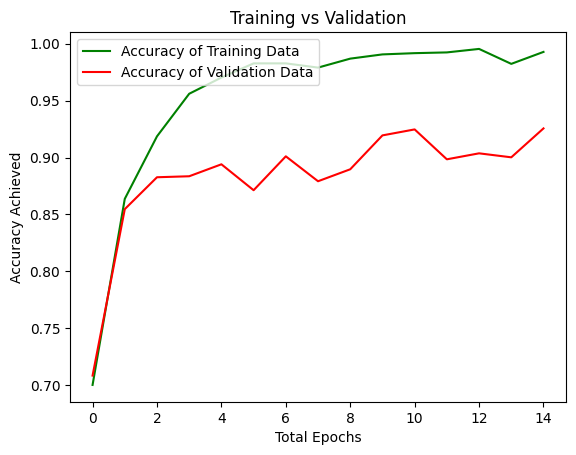

In [50]:
plt.plot(epochs, history.history['accuracy'], 'green', label='Accuracy of Training Data')
plt.plot(epochs, history.history['val_accuracy'], 'red', label='Accuracy of Validation Data')
plt.xlabel("Total Epochs")
plt.ylabel("Accuracy Achieved")
plt.title("Training vs Validation")
plt.legend(loc='upper left')
plt.show()

### Visualizing and Predicting 2ⁿᵈ batch of our test data

1/1 [==============================] - 0s 17ms/step


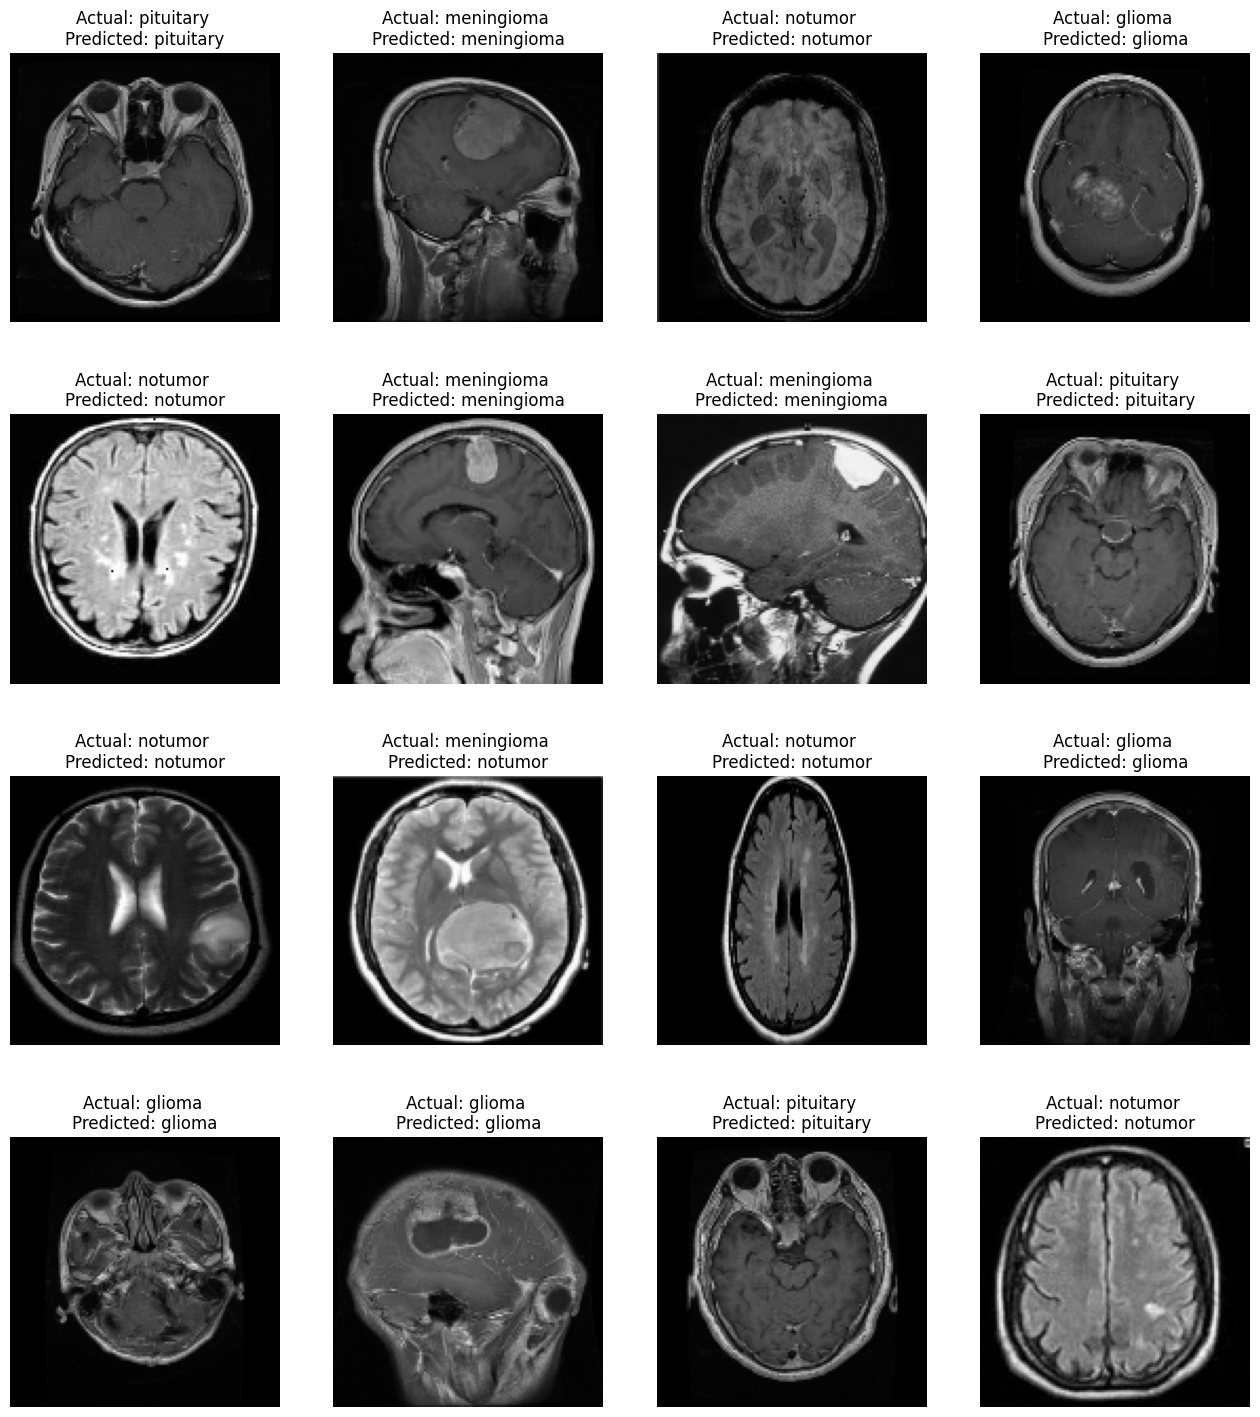

In [48]:
images, labels = next(normalized_test_ds.as_numpy_iterator())
images, labels = next(normalized_test_ds.as_numpy_iterator())
plt.figure(figsize=(16, 18))
for i in range(len(images)):
  plt.subplot(4, 4, i + 1)
  plt.imshow((images[i] * 256).astype("uint8"))
  main_img = np.expand_dims(images[i], 0)
  prediction = cnn.predict(main_img)
  predicted_class = classes[np.argmax(prediction[0])]
  actual_class = classes[labels[i]]
  plt.title(f"Actual: {actual_class} \nPredicted: {predicted_class}")
  plt.axis("off")
